In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from tiktaktoe import *
from IPython.display import clear_output

In [2]:
batch_size = 30000
total_batches = 100

epsilon = 0.5

In [3]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        
        # Define the layers
        self.flatten = nn.Flatten()  # In case your input is a 3x9 tensor and needs to be flattened
        self.fc1 = nn.Linear(27, 25)  # Input layer (3x9 = 27 neurons) -> First hidden layer (25 neurons)
        self.fc2 = nn.Linear(25, 25)  # First hidden layer (25 neurons) -> Second hidden layer (25 neurons)
        self.fc3 = nn.Linear(25, 9)   # Second hidden layer (25 neurons) -> Output layer (9 neurons)
        
        # Activation function (ReLU in this case)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Forward pass through the network
        x = self.flatten(x)  # Flatten input (if necessary)
        x = self.relu(self.fc1(x))  # First hidden layer with ReLU
        x = self.relu(self.fc2(x))  # Second hidden layer with ReLU
        x = self.fc3(x)  # Output layer (no activation here for now, might add Softmax if needed)
        return x

# Example of instantiating the model
model = NN()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
torch.cuda.is_available()

False

In [5]:
player_1 = RandomPlayer()
player_2 = NNPlayer(model=model)

game = TikTakToe(starting_player_x=player_1, second_player_o=player_2)

In [6]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def update_network(model, experiences):
    model.train()
    batch = random.sample(experiences, batch_size)
    states = torch.stack([exp['state'] for exp in batch])  # Batch of states
    actions = torch.tensor([exp['action'] for exp in batch])  # Batch of actions
    rewards = torch.tensor([exp['reward'] for exp in batch], dtype=torch.float32)  # Batch of rewards

    states = states.to(device)
    actions = actions.to(device)
    rewards = rewards.to(device)

    # Forward pass: Get predicted Q-values from the network
    predicted_q_values = model(states)

    # Gather the Q-values corresponding to the actions taken in the batch
    predicted_q_values_for_actions = predicted_q_values.gather(1, actions.unsqueeze(1)).squeeze(1)

    # Get the Q-values for the next states from the target network (no gradients for this)
    #with torch.no_grad():
    #    next_q_values = target_model(next_states)
    #    max_next_q_values = next_q_values.max(1)[0]  # Max Q-value for the next state (best action)

    # Compute target Q-values using the Bellman equation
    target_q_values = rewards # + (gamma * max_next_q_values)

    # Compute the loss (Mean Squared Error between target and predicted Q-values)
    loss = F.mse_loss(predicted_q_values_for_actions, target_q_values)

    # Zero gradients, backpropagate the loss, and update the network weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()


In [7]:
batch_results = list() # stores dicts like this: {'batch_nr': x, 'qplayer_wins': y, 'draws': z, 'qplayer_loss': t}
test_results = list() # stores dicts like this: {'batch_nr': x, 'qplayer_wins': y, 'draws': z, 'qplayer_loss': t}
experiences = list() # stores dicts like this {state, action, reward}

# training loop
qplayer_wins = 0
random_wins = 0
draws = 0


def update_scores(result, qplayernr):
    global qplayer_wins, random_wins, draws
    if result == 'draw':
        draws += 1
        return
    if qplayernr == PlayerNr.X:
        if result == 'x_win':
            qplayer_wins += 1
        if result == 'o_win':
            random_wins += 1
    if qplayernr == PlayerNr.O:
        if result == 'o_win':
            qplayer_wins += 1
        if result == 'x_win':
            random_wins += 1

# testing loop
qplayer_wins_test = 0
random_wins_test = 0
draws_test = 0

def update_test_scores(result, qplayernr):
    global qplayer_wins_test, random_wins_test, draws_test
    if result == 'draw':
        draws_test += 1
        return
    if qplayernr == PlayerNr.X:
        if result == 'x_win':
            qplayer_wins_test += 1
        if result == 'o_win':
            random_wins_test += 1
    if qplayernr == PlayerNr.O:
        if result == 'o_win':
            qplayer_wins_test += 1
        if result == 'x_win':
            random_wins_test += 1
        
def update_experiences(result, moves_made):
    if result == 'draw':
        for move in moves_made:
            experiences.append({'state': move[1], 'action': move[2], 'reward': 1})
    if result == 'x_win':
        for move in moves_made:
            if move[0] == PlayerNr.X:
                reward = 10
            else:
                reward = -15
            experiences.append({'state': move[1], 'action': move[2], 'reward': reward})
    if result == 'o_win':
        for move in moves_made:
            if move[0] == PlayerNr.O:
                reward = 10
            else:
                reward = -15
            experiences.append({'state': move[1], 'action': move[2], 'reward': reward})

def play_game(moves_made, epsilon=0, testing=False):
    if random.random() < .5: # coinflip who starts out
        game = TikTakToe(starting_player_x=player_1, second_player_o=player_2)
        while game.is_ongoing:
            player_1.take_field(game)
            if not game.is_ongoing:
                break
            player_2.take_field(game, moves_made, epsilon)

        if testing:
            update_test_scores(game.result, qplayernr=PlayerNr.O)
        else:
            update_scores(game.result, qplayernr=PlayerNr.O)
            update_experiences(game.result, moves_made)
        game.reset()
    else:
        game = TikTakToe(starting_player_x=player_2, second_player_o=player_1)
        while game.is_ongoing:
            player_2.take_field(game, moves_made, epsilon)
            if not game.is_ongoing:
                break
            player_1.take_field(game)

        if testing:
            update_test_scores(game.result, qplayernr=PlayerNr.X)
        else:
            update_scores(game.result, qplayernr=PlayerNr.X)
            update_experiences(game.result, moves_made)
        game.reset()




for batch in range(total_batches):
    for episode in range(batch_size):

        moves_made = list()
        play_game(moves_made, epsilon)

    
    batch_results.append({'batch_nr': batch, 'qplayer_wins': qplayer_wins, 'random_wins': random_wins, 'draws': draws})
    
    update_network(model, experiences)

    # testing
    for episode in range(batch_size):

        moves_made = list()
        play_game(moves_made, epsilon=0, testing=True)

    
    test_results.append({'batch_nr': batch, 'qplayer_wins': qplayer_wins_test, 'random_wins': random_wins_test, 'draws': draws_test})
    print(f"Batch: {batch}/{total_batches}")
    
    qplayer_wins = 0
    random_wins = 0
    draws = 0

Batch: 0/100
Batch: 1/100
Batch: 2/100
Batch: 3/100
Batch: 4/100
Batch: 5/100
Batch: 6/100
Batch: 7/100
Batch: 8/100
Batch: 9/100
Batch: 10/100
Batch: 11/100
Batch: 12/100
Batch: 13/100
Batch: 14/100
Batch: 15/100
Batch: 16/100
Batch: 17/100
Batch: 18/100
Batch: 19/100
Batch: 20/100
Batch: 21/100
Batch: 22/100
Batch: 23/100
Batch: 24/100
Batch: 25/100
Batch: 26/100
Batch: 27/100
Batch: 28/100
Batch: 29/100
Batch: 30/100
Batch: 31/100
Batch: 32/100
Batch: 33/100
Batch: 34/100
Batch: 35/100
Batch: 36/100
Batch: 37/100
Batch: 38/100
Batch: 39/100
Batch: 40/100
Batch: 41/100
Batch: 42/100
Batch: 43/100
Batch: 44/100
Batch: 45/100
Batch: 46/100
Batch: 47/100
Batch: 48/100
Batch: 49/100
Batch: 50/100
Batch: 51/100
Batch: 52/100
Batch: 53/100
Batch: 54/100
Batch: 55/100
Batch: 56/100
Batch: 57/100
Batch: 58/100


In [8]:
batch_results

[{'batch_nr': 0, 'qplayer_wins': 168, 'random_wins': 279, 'draws': 53},
 {'batch_nr': 1, 'qplayer_wins': 192, 'random_wins': 246, 'draws': 62},
 {'batch_nr': 2, 'qplayer_wins': 174, 'random_wins': 269, 'draws': 57},
 {'batch_nr': 3, 'qplayer_wins': 201, 'random_wins': 228, 'draws': 71},
 {'batch_nr': 4, 'qplayer_wins': 216, 'random_wins': 205, 'draws': 79},
 {'batch_nr': 5, 'qplayer_wins': 228, 'random_wins': 216, 'draws': 56},
 {'batch_nr': 6, 'qplayer_wins': 226, 'random_wins': 224, 'draws': 50},
 {'batch_nr': 7, 'qplayer_wins': 234, 'random_wins': 211, 'draws': 55},
 {'batch_nr': 8, 'qplayer_wins': 240, 'random_wins': 218, 'draws': 42},
 {'batch_nr': 9, 'qplayer_wins': 268, 'random_wins': 187, 'draws': 45},
 {'batch_nr': 10, 'qplayer_wins': 267, 'random_wins': 181, 'draws': 52},
 {'batch_nr': 11, 'qplayer_wins': 280, 'random_wins': 170, 'draws': 50},
 {'batch_nr': 12, 'qplayer_wins': 282, 'random_wins': 160, 'draws': 58},
 {'batch_nr': 13, 'qplayer_wins': 290, 'random_wins': 171, 'd

# PLOT

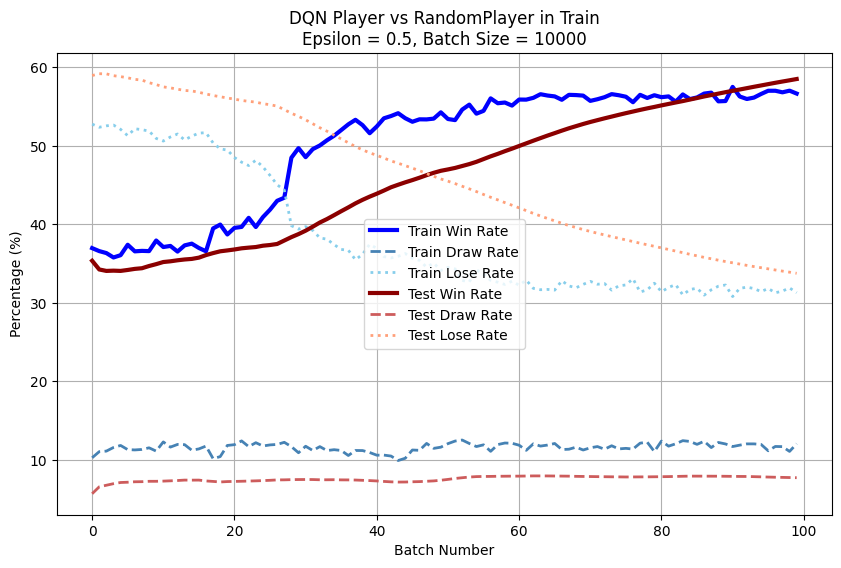

In [8]:
import matplotlib.pyplot as plt

# Extracting batch numbers, win rates, lose rates, and draw rates for both train and test results
train_batch_nr = [entry['batch_nr'] for entry in batch_results]
test_batch_nr = [entry['batch_nr'] for entry in test_results]

def calculate_rates(results):
    qplayer_wins = [entry['qplayer_wins'] for entry in results]
    random_wins = [entry['random_wins'] for entry in results]
    draws = [entry['draws'] for entry in results]
    total_games = [q + r + d for q, r, d in zip(qplayer_wins, random_wins, draws)]
    
    win_rates = [q / total * 100 for q, total in zip(qplayer_wins, total_games)]
    lose_rates = [r / total * 100 for r, total in zip(random_wins, total_games)]
    draw_rates = [d / total * 100 for d, total in zip(draws, total_games)]
    
    return win_rates, lose_rates, draw_rates

# Calculate rates for train and test
train_win_rates, train_lose_rates, train_draw_rates = calculate_rates(batch_results)
test_win_rates, test_lose_rates, test_draw_rates = calculate_rates(test_results)



# Plotting
plt.figure(figsize=(10, 6))

# Define a new set of colors for each line
# Define new shades for each line (shades of blue for train, shades of red for test)
train_win_color = '#0000FF'  # Dark blue
train_draw_color = '#4682B4'  # Medium blue
train_lose_color = '#87CEEB'  # Light blue
test_win_color = '#8B0000'  # Dark red
test_draw_color = '#CD5C5C'  # Medium red
test_lose_color = '#FFA07A'  # Light red

# Train results (blue)
# Train results with different colors
plt.plot(train_batch_nr, train_win_rates, color=train_win_color, label="Train Win Rate", linewidth=3)  # Thick line
plt.plot(train_batch_nr, train_draw_rates, color=train_draw_color, label="Train Draw Rate", linestyle='--', linewidth=2)  # Dashed line
plt.plot(train_batch_nr, train_lose_rates, color=train_lose_color, label="Train Lose Rate", linestyle=':', linewidth=2)  # Dotted line

# Test results with different colors
plt.plot(test_batch_nr, test_win_rates, color=test_win_color, label="Test Win Rate", linewidth=3)  # Thick line
plt.plot(test_batch_nr, test_draw_rates, color=test_draw_color, label="Test Draw Rate", linestyle='--', linewidth=2)  # Dashed line
plt.plot(test_batch_nr, test_lose_rates, color=test_lose_color, label="Test Lose Rate", linestyle=':', linewidth=2)  # Dotted line

# Labels and title
plt.xlabel('Batch Number')
plt.ylabel('Percentage (%)')
# title with hyperparameters
plt.title(f'DQN Player vs RandomPlayer in Train\n'
           f'Epsilon = {epsilon}, Batch Size = {batch_size}')

# Adding a legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()